In [71]:
import pandas as pd 
import numpy as np
import networkx
from tqdm import tqdm
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)
import random 
import matplotlib.pyplot as plt
from collections import defaultdict
import operator

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
 path = '/content/drive/My Drive/Sapienza/ADM/HW5/data/'

# General Notes 
## This section is dedicated to the data preprocessing

There are three files  to be preprocessed and used in further analysis. In 'wikigraph_reduced.csv', every row indicates an edge. In particular, the two elements are the source and the target, respectively. 

In addition, two files containing page names of the articles and the categories of the articles are provided; these are 'wiki-topcats-page-names.txt' and 'wiki-topcats-categories.txt' respectively. 

####  File with Edge
Here we prepare the file by putting separator, giving names to columns and etc

In [5]:
df= pd.read_csv(path +'wikigraph_reduced.csv', sep='\t',  names=['Source','Target'] )
df= df.iloc[1:]
df.reset_index(drop=True,inplace=True)
df.head(2)

,Source,Target
0,95,1185516
1,108,1059989


In [7]:
print('All edges = ' + str(df.shape[0]))
print('Tot articles = ' + str(pd.concat([df.Source, df.Target]).nunique()))

All edges = 483094
Tot articles = 98343


####  File with Categories

In this part, we work with 'wiki-topcats-categories.txt' file. Firstly we clean 'Category' column firstly by splitting it and then choosing only necessary part. Secondly, we split 'Articles' column to be able to work with it. 

Thirdly, we assign each article to a new row with corresponding categories because one article might belong to multiple categories. 

In [57]:
df_cat = pd.read_csv(path + 'wiki-topcats-categories.txt', sep=';',names=['Category','Articles'],header=0)
df_cat.head(2) # this is how it looked initially

,Category,Articles
0,Category:People_from_Worcester,1056 1057 1058 1059 1060 60971 76515 76871 78...
1,Category:Skin_conditions_resulting_from_physic...,971 973 1166 1167 1168 1169 1170 1171 1172 11...


In [58]:
def cat_clean(df_cat):
  df_cat['Category']=df_cat.Category.str.split(':')# firstly
  df_cat['Category']=df_cat.Category.str[1]
  df_cat['Articles']=df_cat.Articles.str.split() # secondly
  df_cat = pd.concat([pd.DataFrame(data = {'Articles': df_cat.loc[i].Articles,  # thirdly
                                              'Category': df_cat.loc[i].Category}) for i in df_cat.index], ignore_index=True)
  
  return df_cat

In [59]:
df_cat = cat_clean(df_cat)
df_cat.head(2)

,Articles,Category
0,1056,People_from_Worcester
1,1057,People_from_Worcester


In this function we want to make each article to belong to one category by applying uniform randomness

In [60]:
def random_choice(df_cat):
  articles_dictionary = {} # here we are making dictionary to find out to which categories each article belongs
  for i in tqdm(range(len(df_cat))): 
      if df_cat.loc[i,"Articles"] not in articles_dictionary: 
          articles_dictionary[df_cat.loc[i,"Articles"]] = [] 
      articles_dictionary[df_cat.loc[i,"Articles"]].append(df_cat.loc[i,"Category"])
  
  for ks in tqdm(articles_dictionary):   # here we are selecting random category that it will belong to
    new_v = random.choice(articles_dictionary[ks]) 
    del articles_dictionary[ks][:] 
    articles_dictionary[ks] = new_v 

  reversed_dictionary = {} # here we are changing the places of articles and categories
  for k, v in tqdm(articles_dictionary.items()):  
      reversed_dictionary.setdefault(v, []) 
      reversed_dictionary[v].append(k) # in the end we will get a category and its list of categories

  return pd.DataFrame(reversed_dictionary.items(), columns=['Category', 'Articles']), reversed_dictionary

In [61]:
df_cat, reversed_dictionary = random_choice(df_cat)
df_cat.head(2)

100%|██████████| 1790947/1790947 [00:01<00:00, 1688490.36it/s]


,Category,Articles
0,English_engineers,"[1056, 1094099, 1094717, 1342675, 1470897, 147..."
1,English_Anglican_priests,"[1057, 1516731, 31509, 885549, 58363, 449802, ..."


In [63]:
len(reversed_dictionary['English_engineers'])

84

#### File with name

In this part we are separating column that contains both the node and the page into two columns

In [10]:
df_name = pd.read_csv(path + "wiki-topcats-page-names.txt", sep="\t", names = ["name"])
page= []
for i in (df_name['name']): 
    page.append(" ".join(i.split()[1:]))
df_name['page'] = page
df_name['name'] = df_name.name.str.split()
df_name['node'] = df_name.name.str[0]
df_name = df_name[['page', 'node']]
df_name.set_index('node', inplace = True)
df_name.head(2)

,page
node,
0,Chiasmal syndrome
1,Kleroterion


# RQ1

### Is the graph directed?

In the function, we create two lists of edges: in one list, columns are inverted and in another columns are not. In case if they are equal we can say that they are not directed because for each edge from x to y there is an edge from y to x. 

In [48]:
df.head(2)

,Source,Target
0,95,1185516
1,108,1059989


In [12]:
def is_directed(df):
  df_inverted = df[df.columns[::-1]] 
  intersection = [v for v in df.values.tolist() if v in df_inverted.values.tolist()] 
  if (intersection == df.values.tolist()): 
      print('Not Directed')
  else:
      print('Directed')

In [24]:
is_directed(df)

Directed


### Generating Graph

Since we concluded that the graph has to be directed, we use the method DiGraph of networkx

In [13]:
def graph_generation(df):
  
  li1 = list(df['Source']) 
  li2 = list(df['Target'])
  G = networkx.DiGraph()    

  for i in tqdm(range(len(df))):
      if li1[i] not in G.nodes: 
          G.add_node(li1[i]) 
      if li2[i] not in G.nodes:
          G.add_node(li2[i]) 
      G.add_edge(li1[i], li2[i], weight=1) 
  return G

In [14]:
G = graph_generation(df)

100%|██████████| 483094/483094 [00:02<00:00, 194551.36it/s]


### How many articles are we considering?

Here, we are just concating two columns and then finding unique nodes which are articles.

In [15]:
print('Tot articles = ' + str(pd.concat([df.Source, df.Target]).nunique()))

Tot articles = 98343


### How many hyperlinks between pages exist?

Since hyperlinks are equal to total number of edges, it is just length of our dataframe

In [16]:
print('Tot hyperlinks = '+ str(df.shape[0]))

Tot hyperlinks = 483094


### Compute the average number of links in an arbitrary page. 

To find the average number of links, we firstly calculated the sum of degrees for every node and then we divided it by number of nodes.

In [17]:
summation = 0 
for i in G.nodes: 
  summation = summation + networkx.degree(G)[i]

print('Average number of links = ' + str(summation/len(G.nodes)))

Average number of links = 9.824674862471147


### What is the graph density?

First of all, a graph is dense if the number of edges is close to the maximum number of edges it can possibly have. Its formula is |E|/(|V|(|V|-1)) where E is numbder of edges and V is number of vertices.

In [18]:
edges = df.shape[0]
nodes = pd.concat([df.Source, df.Target]).nunique()
print ('Graph Density = ' + str(edges/(nodes*(nodes-1))))

Graph Density = 4.9951571365597335e-05


Our graph is relatively really sparse because the maximum density is 1 and our graph's density is approximately 0.00005

### Visualize the nodes' degree distribution

In [55]:
df.head(2)

,Source,Target
0,95,1185516
1,108,1059989


In [21]:
def distribution_plot(G):
    dis = [len(G[i]) for i in G]
    norm =[(float(i)/sum(dis)) for i in dis]

    plt.figure(figsize=(20,9))
    plt.plot(range(len(dis)),norm)
    plt.title('Nodes Degree Distribution')
    plt.show()

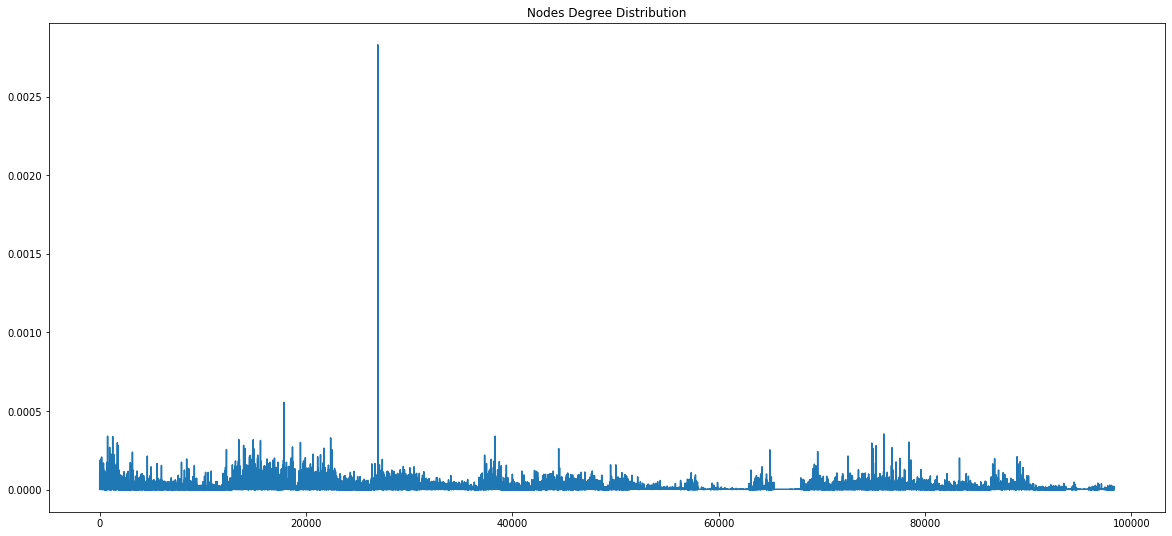

In [22]:
distribution_plot(G)

# RQ2
Define a function that takes in input:

A page v

---


A number of clicks d


---






and returns the set of all pages that a user can reach within d clicks.

The starting node is the first visited node and it is firstly included in our list of nodes. Then, we iterate through all the clicks. For the first iteration we have neigbours of our first node and we add it to the list  'all_nodes' and then we replace our inital list with 'all_nodes'. We do this proces for each click.

 I added tqdm for iterations to keep count of our progress. Here, the growth is exponential: more clicks we add, even more nodes we will have in our list. So, for example, 10th click might be computationally really expensive.

In [45]:
def max_click_reach(G, node, clicks):
    nodes = [node] 
    for i in tqdm(range(clicks)): 
        all_nodes =[] 
        for n in nodes:
            for neighbour in G[n]: 
                all_nodes.append(neighbour)  
        nodes = all_nodes
    final_set = set(all_nodes)
    return final_set 

In [42]:
len(max_click_reach(G, 1055135, 1))

100%|██████████| 1/1 [00:00<00:00, 4232.40it/s]


7

In [43]:
len(max_click_reach(G, 1055135, 5)) # In five clicks you have options to visit 35570 nodes and one iteration is doone in 1/6 seconds

100%|██████████| 5/5 [00:00<00:00,  5.75it/s]


35570

In [44]:
len(max_click_reach(G, 1055135, 6)) # On the sixth click, now, it takes 3 seconds on average to run just one iteration 
#  So, the difference between the fifth and sixth clicks is immense. 

100%|██████████| 6/6 [00:19<00:00,  3.19s/it]


44681

# RQ3
Define a function that takes in input:


---


A category C


---


A set of pages in C, p = {p1, ..., pn}


---


and returns the minimum number of clicks required to reach all pages in p, starting from the page v, corresponding to the most central article, according to the in-degree centrality, in C.

Before implementing our algorithm, we have to create a dictionary, 'dictionary_degree', in which each node is mapped to its out-degree. 

In [51]:
dictionary_degree = defaultdict(int)
for i in G:
  dictionary_degree[i]= len(G[i])

In [55]:
dictionary_degree[95]

1

In the function below,  we used the Breadth First Search algorithm to reach our goal

In [74]:
def Breadth_First_Search(G, reversed_dictionary, dictionary_degree):
    cat = input('Insert the category: ')
    pages = reversed_dictionary["{}".format(cat)]
    pages_array = list(map(int,pages)) 

    degree_value= {i: dictionary_degree[i] for i in pages_array} 
    highest_degree_node = max(degree_value.items(), key=operator.itemgetter(1))[0] 

    v_nodes = [] 
    neigbours_queue = []   
    v_nodes.append(highest_degree_node) 
    neigbours_queue.append(highest_degree_node)   
    quantity_visited_levels=0
    while pages_array and neigbours_queue: 
        s = neigbours_queue.pop(0) 

        for neighbour in G[s]:  
            if neighbour not in v_nodes: 
                v_nodes.append(neighbour) 
                neigbours_queue.append(neighbour) 
                if neighbour in pages_array:
                    pages_array.remove(neighbour) 

        quantity_visited_levels = quantity_visited_levels + 1 

    if len(pages_array)>0:
        print('Not Possible')
    else:
        print('Found')
        
    return quantity_visited_levels 

In [75]:
Breadth_First_Search(G, reversed_dictionary, dictionary_degree)

Insert the category: 20th-century_Bah's
Not Possible


64011

# RQ4

Given in input two categories: C1 and C2, we get the subgraph induced by all the articles in the two categories.

Let v and u two arbitrary pages in the subgraph. What is the minimum set of hyperlinks one can remove to disconnect u and v?

In the function below, a subgraph between two categories is created. Since we are interested in disconnection, undirected graph is used and this will improve our solution and computation.

In [78]:
def create_subgraph(G, reversed_dictionary):
    
    c1 = input('Insert C1: ')
    c2 = input('Insert C2: ')
    n1 = list(map(int,reversed_dictionary["{}".format(c1)]))
    n2 = list(map(int,reversed_dictionary["{}".format(c2)]))
    total_nodes = n1 + n2
  
    return networkx.Graph(G.subgraph(total_nodes).copy())

In [87]:
df_cat.head(10)

,Category,Articles
0,English_engineers,"[1056, 1094099, 1094717, 1342675, 1470897, 147..."
1,English_Anglican_priests,"[1057, 1516731, 31509, 885549, 58363, 449802, ..."
2,British_television_presenters,"[1058, 42939, 158274, 164938, 943302, 1003324,..."
3,People_from_Worcester,"[1059, 1060, 84108, 84740, 158412, 166087, 194..."
4,16th-century_English_people,"[60971, 1143243, 1144198, 1142211, 1144581, 21..."
5,English_footballers,"[76515, 78094, 89734, 1295678, 89362, 82788, 8..."
6,English_football_managers,"[76871, 74816, 74988, 82953, 82746, 74981, 873..."
7,Association_football_midfielders,"[79069, 803230, 26916, 27006, 27740, 28027, 28..."
8,Wolverhampton_Wanderers_F.C._players,"[79139, 76815, 86419, 80397, 74872, 80159, 780..."
9,Living_people,"[79143, 80237, 499532, 538870, 826926, 883273,..."


In [91]:
subgraph = create_subgraph(G, reversed_dictionary)

Insert C1: English_engineers
Insert C2: English_Anglican_priests


In [96]:
subgraph2 = create_subgraph(G, reversed_dictionary)

In the function below,   the Breadth First Search algorithm is used with an exception that we stop iterating when we find a connection between two nodes

In [106]:
def Breadth_First_Search_Modified(G, node1, node2):

    path_two_nodes=[]
    parents={}
    flag=False 
    pages = [] 
    neigbours_queue = []   
    pages.append(node1) 
    neigbours_queue.append(node1)  
    quantity_visited_levels=0
    while neigbours_queue: 
        s = neigbours_queue.pop(0) 

        for n in G[s]: 
            if n not in pages: 
                parents[n]=s
                pages.append(n) 
                neigbours_queue.append(n) 
                if n==node2:    
                    path_two_nodes = [node2]
                    while path_two_nodes[-1] != node2:
                        path_two_nodes.append(parents[path_two_nodes[-1]])
                    path_two_nodes.reverse()    
                    flag=True  
                    # print('Found') 
                    break 
       
        quantity_visited_levels= quantity_visited_levels+1  

    return quantity_visited_levels, path_two_nodes, flag

Finally, in this function we keep running iteratively the function "Breadth_First_Search_Modified" until paths  between "node1" and "node2" are being found

In [109]:
def minimum_hyperlinks_cut(G, node1, node2):

    gcopy= G.copy()
    minimum_edges=0
    quantity_visited_levels, path_two_nodes, flag = Breadth_First_Search_Modified(gcopy,node1, node2)
    print(path_two_nodes)

    while flag:
        minimum_edges= minimum_edges + 1
        # print(minimum_edges)
        i=0
        while i < len(path_two_nodes)-1:  # here, we are moving edges between nodes
            try:
                gcopy.remove_edge(path_two_nodes[i],path_two_nodes[i+1]) # we remove edges from both sides
            except:
                gcopy.remove_edge(path_two_nodes[i+1],path_two_nodes[i])
            i = i + 1

        quantity_visited_levels, path_two_nodes, flag = Breadth_First_Search_Modified(gcopy, node1, node2)

    return minimum_edges

In [92]:
list(subgraph.nodes)

[63104, 30884, 1144582, 449612, 449585, 1145298]

In [93]:
minimum_hyperlinks_cut(subgraph, 63104, 30884) 

[]


0

# RQ5

Write a function that, given an arbitrary category C0 as input, returns the list of remaning categories sorted by their distance from C0. In particular, the distance between two categories is defined as


---


distance(C0, Ci) = median(ShortestPath(C0, Ci))


---






where ShortestPath(C0, Ci) is the set of shortest paths from each pair of nodes in the two categories.

This function returns the shortest path from source node to all other articles. 
    

In [115]:
def shortest_distance(G, source, art):

    v_nodes = [node]
    level = [node]
    
    distances = dict.fromkeys(art, -1)
    quantity_visited_levels = 1
    while True:
        new_level = []
        for article in level:
            for adj in G.incident_edges(article):
                if adj not in v_nodes:
                    new_level.append(adj)
                    v_nodes.append(adj)
                    if adj in art:
                        distances[adj] = quantity_visited_levels
        if len(new_level) == 0:
            break
        level = new_level
        quantity_visited_levels = quantity_visited_levels + 1
    
    if (np.array(list(distances.values())) == -1).all():
        return -1
    else:
        shortest_distance = min([di for article, di in distances.items() if di != -1])
        
    return shortest_distance

After indicating input category, the function below in the end gives a list of other categories that are sorted by the distance frpm our input category

In [119]:
def distance_between_categories(G, reversed_dictionary, category_name):
    
    category_distances = {}
    
    for cat, art in tqdm(reversed_dictionary.items()):
        shortest_path = {}
        art = [int(article) for article in art if article in G.nodes()]   
        if cat != category_name:
            for node in reversed_dictionary[category_name]:
                if node in G.nodes():
                    shortest_dist = shortest_distance(G, int(node), art) 
                    
                    if shortest_dist == -1: 
                         continue
                    else:
                        shortest_path[node] = shortest_dist
            
            if len(shortest_path) == 0:
                continue
            else:
                median = np.median([shortest for node, shortest in shortest_path.items()])
                category_distances[cat] = median
    if len(category_distances) == 0:
        return 'No other connection'
    else:
        return dict(sorted(category_distances.items(), key=lambda item: item[1]))

In [120]:
distance_between_categories(G, reversed_dictionary, 'Association_football_forwards')

100%|██████████| 17352/17352 [00:14<00:00, 1215.05it/s]


'No other connection'